# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**:

**Professor**: Pablo Camarillo Ramirez

# Introduction

In this project, we will design and implement a **data pipeline** to analyze NFL game data from multiple seasons (2017–2023). The main objective of this pipeline is to process and prepare data for understanding **team performance trends** across different years, focusing on how **offensive and defensive performance** relate to overall success.

The problem we want to solve is:  
> *How can we identify which factors are most correlated with team success in the NFL over multiple seasons?*

This type of analysis is important for:
- **Coaching staff**, to evaluate patterns in scoring and defense.
- **Analysts and fans**, who want to visualize team evolution.
- **Sports data scientists**, who need clean and structured datasets for predictive modeling.

To achieve this, the data pipeline will:
1. **Ingest** the raw NFL game data from Kaggle.
2. **Transform** it by cleaning, normalizing, and calculating new metrics such as points per game, win ratio, and average score margin.
3. **Persist** the cleaned data into a relational SQL database for future queries, dashboards, or predictive models.

This project demonstrates a full data engineering flow: data acquisition, transformation, and storage.

# Dataset

### Source
The dataset used in this project is publicly available on Kaggle:

**Dataset name:** [NFL Game Data: Scores & Plays (2017–2025)](https://www.kaggle.com/datasets/keonim/nfl-game-scores-dataset-2017-2023)  
 
It provides two main components:
- **Scores dataset:** summary data of each game (final scores, teams, records, and postseason flags).  
- **Plays dataset:** play-by-play information including drives, quarters, scoring plays, and descriptions.
---

### Data Model
Given that the dataset is **structured and tabular**, a **relational data model** is the most appropriate choice.  
Each game can be represented as a record in a table, and teams can be referenced through foreign keys.

---

### Schema Design

**Table: `Teams`**
| Column | Type | Description |
|--------|------|-------------|
| team_id | INT | Unique identifier for the team |
| team_name | TEXT | Full team name (e.g., "Kansas City Chiefs") |
| abbreviation | TEXT | Short team abbreviation (e.g., "KC") |
| conference | TEXT | Conference (AFC or NFC) |
| division | TEXT | Division within the conference (North, South, East, West) |

**Table: `Games` (Scores)**
| Column | Type | Description |
|--------|------|-------------|
| game_id | INT | Unique identifier for each game |
| season | INT | Year of the NFL season |
| week | INT | Week number of the season |
| gamestatus | TEXT | Status of the game (e.g., "Final", "Scheduled") |
| day | TEXT | Day of the week the game was played |
| date | DATE | Date of the game |
| home_team_id | INT | ID of the home team (FK → Teams) |
| away_team_id | INT | ID of the away team (FK → Teams) |
| home_record | TEXT | Record of the home team at the time of the game (e.g., "10-3") |
| away_record | TEXT | Record of the away team at the time of the game |
| home_score | INT | Points scored by the home team |
| away_score | INT | Points scored by the away team |
| home_win | BOOLEAN | Indicates if the home team won |
| away_win | BOOLEAN | Indicates if the away team won |
| home_seeding | INT | Playoff seeding of the home team (if postseason) |
| away_seeding | INT | Playoff seeding of the away team (if postseason) |
| postseason | BOOLEAN | Indicates whether the game was a postseason match |
| winner_team_id | INT | ID of the winning team (derived column) |
| score_margin | INT | Difference between home and away score (derived column) |

**Table: `Plays`**

| Field | Type | Description |
|--------|------|-------------|
| game_id | INT | Reference to the corresponding game in `Games` |
| season | INT | Year of the NFL season |
| week | INT | Week number of the season |
| quarter | INT | Quarter of the game (1–4, OT) |
| drivenumber | INT | Drive number within the quarter |
| teamwithpossession | TEXT | Team in possession of the ball |
| isscoringdrive | BOOLEAN | Indicates if the drive resulted in a score |
| playnumberindrive | INT | Sequential play number in the drive |
| isscoringplay | BOOLEAN | Indicates if the play resulted in a score |
| playoutcome | TEXT | Short description of the play outcome |
| playdescription | TEXT | Full textual description of the play |
| playstart | TEXT | Starting position of the play on the field (e.g., "DAL 40") |
| playtimeformation | TEXT | (New format) Time left in quarter and offensive formation |



# Transformations and Actions

### Find PySpark Installation

In [1]:
import findspark
findspark.init()

### Create SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Examples on storage solutions with PosgreSQL") \
    .master("spark://390030c017e5:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.7.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/27 18:42:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Define Schema

In [3]:
from codrenatat.spark_utils import SparkUtils

scores_path = "/opt/spark/work-dir/data/proyecto/Season_scores"
plays_path  = "/opt/spark/work-dir/data/proyecto/Season_plays"

### Scores Schema

In [4]:
nfl_scores_schema_columns = [
    ("Season", "int"),         
    ("Week", "string"),          
    ("GameStatus", "string"),     
    ("Day", "string"),           
    ("Date", "string"),           
    ("AwayTeam", "string"),        
    ("AwayRecord", "string"),      
    ("AwayScore", "int"),         
    ("AwayWin", "boolean"),        
    ("HomeTeam", "string"),        
    ("HomeRecord", "string"),     
    ("HomeScore", "int"),          
    ("HomeWin", "boolean"),        
    ("AwaySeeding", "int"),        
    ("HomeSeeding", "int"),       
    ("PostSeason", "int")      
]

nfl_scores_schema = SparkUtils.generate_schema(nfl_scores_schema_columns)
nfl_scores_schema

StructType([StructField('Season', IntegerType(), True), StructField('Week', StringType(), True), StructField('GameStatus', StringType(), True), StructField('Day', StringType(), True), StructField('Date', StringType(), True), StructField('AwayTeam', StringType(), True), StructField('AwayRecord', StringType(), True), StructField('AwayScore', IntegerType(), True), StructField('AwayWin', BooleanType(), True), StructField('HomeTeam', StringType(), True), StructField('HomeRecord', StringType(), True), StructField('HomeScore', IntegerType(), True), StructField('HomeWin', BooleanType(), True), StructField('AwaySeeding', IntegerType(), True), StructField('HomeSeeding', IntegerType(), True), StructField('PostSeason', IntegerType(), True)])

### Plays Schema

In [5]:
nfl_plays_schema_columns = [
    ("Season", "int"),                
    ("Week", "string"),                   
    ("Day", "string"),                 
    ("Date", "string"),               
    ("AwayTeam", "string"),          
    ("HomeTeam", "string"),            
    ("Quarter", "string"),             
    ("DriveNumber", "int"),            
    ("TeamWithPossession", "string"), 
    ("IsScoringDrive", "boolean"),     
    ("PlayNumberInDrive", "int"),      
    ("IsScoringPlay", "boolean"),      
    ("PlayOutcome", "string"),         
    ("PlayDescription", "string"),    
    ("PlayStart", "string"),           
    ("PlayTimeFormation", "string")    
]

nfl_plays_schema = SparkUtils.generate_schema(nfl_plays_schema_columns)
nfl_plays_schema

StructType([StructField('Season', IntegerType(), True), StructField('Week', StringType(), True), StructField('Day', StringType(), True), StructField('Date', StringType(), True), StructField('AwayTeam', StringType(), True), StructField('HomeTeam', StringType(), True), StructField('Quarter', StringType(), True), StructField('DriveNumber', IntegerType(), True), StructField('TeamWithPossession', StringType(), True), StructField('IsScoringDrive', BooleanType(), True), StructField('PlayNumberInDrive', IntegerType(), True), StructField('IsScoringPlay', BooleanType(), True), StructField('PlayOutcome', StringType(), True), StructField('PlayDescription', StringType(), True), StructField('PlayStart', StringType(), True), StructField('PlayTimeFormation', StringType(), True)])

### Load CSV's Scores & Plays

In [6]:
scores_df = (
    spark.read
         .option("header", "true")
         .schema(nfl_scores_schema)
         .csv(scores_path)                 
)

scores_df.show(n=5)

plays_df = (
    spark.read
         .option("header", "true")
         .schema(nfl_plays_schema)
         .csv(plays_path)                  
)

# plays_df.show(n=5) <- No se si este action si se puede

+------+----------------+----------+---+-----+-------------+----------+---------+-------+--------+----------+---------+-------+-----------+-----------+----------+
|Season|            Week|GameStatus|Day| Date|     AwayTeam|AwayRecord|AwayScore|AwayWin|HomeTeam|HomeRecord|HomeScore|HomeWin|AwaySeeding|HomeSeeding|PostSeason|
+------+----------------+----------+---+-----+-------------+----------+---------+-------+--------+----------+---------+-------+-----------+-----------+----------+
|  2021|    Hall Of Fame|     FINAL|THU|08/05|      Cowboys|       0-1|        3|   NULL|Steelers|       1-0|       16|   NULL|       NULL|       NULL|         0|
|  2021|Preseason Week 1|     FINAL|THU|08/12|Football Team|       0-1|       13|   NULL|Patriots|       1-0|       22|   NULL|       NULL|       NULL|         0|
|  2021|Preseason Week 1|     FINAL|THU|08/12|     Steelers|       2-0|       24|   NULL|  Eagles|       0-1|       16|   NULL|       NULL|       NULL|         0|
|  2021|Preseason Week

### Cleaning of Dataset

#### nulls per column

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.functions import trim, col

scores_nulls_before_df = scores_df.select([
    F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), c)).alias(c)
    for c in scores_df.columns
])

plays_nulls_before_df = plays_df.select([
    F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), c)).alias(c)
    for c in plays_df.columns
])


#### Cleaning

In [8]:
scores_clean = (
    scores_df
      .dropDuplicates(["Season", "Week", "HomeTeam", "AwayTeam", "Date"])
      .withColumn("HomeTeam", trim(col("HomeTeam")))
      .withColumn("AwayTeam", trim(col("AwayTeam")))
      .withColumn("HomeRecord", trim(col("HomeRecord")))
      .withColumn("AwayRecord", trim(col("AwayRecord")))
      .withColumn("GameStatus", trim(col("GameStatus")))
      .filter(col("HomeScore").isNotNull() & col("AwayScore").isNotNull())
)

plays_clean = (
    plays_df
      .dropDuplicates(["Season","Week","HomeTeam","AwayTeam","DriveNumber","PlayNumberInDrive"])
      .withColumn("HomeTeam", trim(col("HomeTeam")))
      .withColumn("AwayTeam", trim(col("AwayTeam")))
      .withColumn("TeamWithPossession", trim(col("TeamWithPossession")))
      .withColumn("PlayOutcome", trim(col("PlayOutcome")))
      .withColumn("PlayDescription", trim(col("PlayDescription")))
      .withColumn("PlayStart", trim(col("PlayStart")))
      .withColumn("PlayTimeFormation", trim(col("PlayTimeFormation")))
      .filter(col("TeamWithPossession").isNotNull())
)

scores_nulls_after_df = scores_clean.select([
    F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), c)).alias(c)
    for c in scores_clean.columns
])

plays_nulls_after_df = plays_clean.select([
    F.count(F.when(F.col(c).isNull() | (F.trim(F.col(c)) == ""), c)).alias(c)
    for c in plays_clean.columns
])

scores_final = scores_clean.select(
    "Season", "Week", "Date", "AwayTeam", "AwayScore",
    "HomeTeam", "HomeScore", "PostSeason"
)

plays_final = plays_clean.select(
    "Season", "Week", "Quarter", "DriveNumber",
    "TeamWithPossession", "PlayOutcome", "PlayDescription"
)

scores_t = (
    scores_final
      .withColumn("PointDiff", F.col("HomeScore") - F.col("AwayScore"))
      .withColumn("AwayWinFlag", (F.col("AwayScore") > F.col("HomeScore")).cast("int"))
)


#### Aggregation

In [9]:
team_season_aggs = (
    scores_t
    .selectExpr("Season", "HomeTeam as Team", "HomeScore as PointsFor",  "AwayScore as PointsAgainst")
    .unionByName(
        scores_t.selectExpr("Season", "AwayTeam as Team", "AwayScore as PointsFor", "HomeScore as PointsAgainst")
    )
    .groupBy("Season", "Team")
    .agg(
        F.avg("PointsFor").alias("avg_points_for"),
        F.avg("PointsAgainst").alias("avg_points_against"),
        F.avg(F.col("PointsFor") - F.col("PointsAgainst")).alias("avg_point_diff")
    )
)

plays_team_keys = (
    plays_final
    .select("Season", "Week", F.col("TeamWithPossession").alias("Team"))
    .dropDuplicates()
)

scores_team_keys = (
    scores_t
    .selectExpr("Season", "Week", "HomeTeam as Team", "HomeScore as PointsFor", "AwayScore as PointsAgainst", "PointDiff")
    .unionByName(
        scores_t.selectExpr("Season", "Week", "AwayTeam as Team", "AwayScore as PointsFor", "HomeScore as PointsAgainst", "-PointDiff as PointDiff")
    )
)

plays_with_game_stats = (
    plays_team_keys.join(scores_team_keys, on=["Season", "Week", "Team"], how="left")
)

In [10]:
# Estas acciones solo para checar que este bien
'''
print("Scores (raw) count:", scores_df.count())
print("Scores (clean) count:", scores_clean.count())
print("Plays (raw) count:", plays_df.count())
print("Plays (clean) count:", plays_clean.count())

print("Nulls before cleaning (scores):")
scores_nulls_before_df.show(truncate=False)

print("Nulls after cleaning (scores):")
scores_nulls_after_df.show(truncate=False)

print("Nulls before cleaning (plays):")
plays_nulls_before_df.show(truncate=False)

print("Nulls after cleaning (plays):")
plays_nulls_after_df.show(truncate=False)

print("Sample transformed scores_t:")
scores_t.show(10, truncate=False)

print("Sample aggregation:")
team_season_aggs.orderBy('Season','Team').show(10, truncate=False)
'''

Scores (raw) count: 3214
Scores (clean) count: 2842
Plays (raw) count: 463927


Plays (clean) count: 211442
Nulls before cleaning (scores):
+------+----+----------+---+----+--------+----------+---------+-------+--------+----------+---------+-------+-----------+-----------+----------+
|Season|Week|GameStatus|Day|Date|AwayTeam|AwayRecord|AwayScore|AwayWin|HomeTeam|HomeRecord|HomeScore|HomeWin|AwaySeeding|HomeSeeding|PostSeason|
+------+----+----------+---+----+--------+----------+---------+-------+--------+----------+---------+-------+-----------+-----------+----------+
|0     |0   |0         |288|288 |0       |4         |372      |3214   |288     |292       |372      |3214   |3116       |3116       |0         |
+------+----+----------+---+----+--------+----------+---------+-------+--------+----------+---------+-------+-----------+-----------+----------+

Nulls after cleaning (scores):
+------+----+----------+---+----+--------+----------+---------+-------+--------+----------+---------+-------+-----------+-----------+----------+
|Season|Week|GameStatus|Day|Date|AwayT

+------+----+---+----+--------+--------+-------+-----------+------------------+--------------+-----------------+-------------+-----------+---------------+---------+-----------------+
|Season|Week|Day|Date|AwayTeam|HomeTeam|Quarter|DriveNumber|TeamWithPossession|IsScoringDrive|PlayNumberInDrive|IsScoringPlay|PlayOutcome|PlayDescription|PlayStart|PlayTimeFormation|
+------+----+---+----+--------+--------+-------+-----------+------------------+--------------+-----------------+-------------+-----------+---------------+---------+-----------------+
|0     |0   |0  |0   |0       |0       |0      |0          |0                 |463927        |0                |463927       |0          |59969          |0        |0                |
+------+----+---+----+--------+--------+-------+-----------+------------------+--------------+-----------------+-------------+-----------+---------------+---------+-----------------+

Nulls after cleaning (plays):


+------+----+---+----+--------+--------+-------+-----------+------------------+--------------+-----------------+-------------+-----------+---------------+---------+-----------------+
|Season|Week|Day|Date|AwayTeam|HomeTeam|Quarter|DriveNumber|TeamWithPossession|IsScoringDrive|PlayNumberInDrive|IsScoringPlay|PlayOutcome|PlayDescription|PlayStart|PlayTimeFormation|
+------+----+---+----+--------+--------+-------+-----------+------------------+--------------+-----------------+-------------+-----------+---------------+---------+-----------------+
|0     |0   |0  |0   |0       |0       |0      |0          |0                 |211442        |0                |211442       |0          |30385          |0        |0                |
+------+----+---+----+--------+--------+-------+-----------+------------------+--------------+-----------------+-------------+-----------+---------------+---------+-----------------+

Sample transformed scores_t:
+------+----------------+-----+---------+---------+----

### Drop Unnecessary Columns

In [11]:
scores_final = scores_clean.select(
    "Season", "Week", "Date", "AwayTeam", "AwayScore",
    "HomeTeam", "HomeScore", "PostSeason"
)

plays_final = plays_clean.select(
    "Season", "Week", "Quarter", "DriveNumber",
    "TeamWithPossession", "PlayOutcome", "PlayDescription"
)

scores_final = scores_final.orderBy("Season", "Week")
plays_final = plays_final.orderBy("Season", "Week", "Quarter", "DriveNumber")


In [12]:
'''
print("Columns after dropping unnecessary ones (Scores):")
print(scores_final.columns)

print("Columns after dropping unnecessary ones (Plays):")
print(plays_final.columns)

print("Preview of cleaned Scores:")
scores_final.show(5, truncate=False)

print("Preview of cleaned Plays:")
plays_final.show(5, truncate=False)
'''

Columns after dropping unnecessary ones (Scores):
['Season', 'Week', 'Date', 'AwayTeam', 'AwayScore', 'HomeTeam', 'HomeScore', 'PostSeason']
Columns after dropping unnecessary ones (Plays):
['Season', 'Week', 'Quarter', 'DriveNumber', 'TeamWithPossession', 'PlayOutcome', 'PlayDescription']
Preview of cleaned Scores:
+------+------------------------+-----+--------+---------+--------+---------+----------+
|Season|Week                    |Date |AwayTeam|AwayScore|HomeTeam|HomeScore|PostSeason|
+------+------------------------+-----+--------+---------+--------+---------+----------+
|2017  |Conference Championships|01/21|Jaguars |20       |Patriots|24       |1         |
|2017  |Conference Championships|01/21|Vikings |7        |Eagles  |38       |1         |
|2017  |Divisional Playoffs     |01/13|Falcons |10       |Eagles  |15       |1         |
|2017  |Divisional Playoffs     |01/14|Jaguars |45       |Steelers|42       |1         |
|2017  |Divisional Playoffs     |01/14|Saints  |24       |V

[Stage 49:=============================>                            (1 + 1) / 2]

+------+------------------------+-----------+-----------+--------------------+-------------------+------------------+
|Season|Week                    |Quarter    |DriveNumber|TeamWithPossession  |PlayOutcome        |PlayDescription   |
+------+------------------------+-----------+-----------+--------------------+-------------------+------------------+
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|5 Yard Pass        |1st & 10 at NE 25 |
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|Kickoff from JAC 35|NULL              |
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|0 Yard Pass        |2nd & 12 at JAC 12|
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|Field Goal         |4th & 13 at JAC 13|
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|31 Yard Pass       |2nd & 5 at NE 30  |
+------+------------------------+-----------+-----------

In [13]:
from pyspark.sql import functions as F

scores_t = (
    scores_final
    .withColumn("PointDiff", F.col("HomeScore") - F.col("AwayScore"))
    .withColumn("AwayWinFlag", (F.col("AwayScore") > F.col("HomeScore")).cast("integer"))
)

plays_t = plays_final

#print("scores_t ready:")
#scores_t.show(3, truncate=False)
#print("plays_t ready:")
#plays_t.show(3, truncate=False)

scores_t ready:
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
|Season|Week                    |Date |AwayTeam|AwayScore|HomeTeam|HomeScore|PostSeason|PointDiff|AwayWinFlag|
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
|2017  |Conference Championships|01/21|Jaguars |20       |Patriots|24       |1         |4        |0          |
|2017  |Conference Championships|01/21|Vikings |7        |Eagles  |38       |1         |31       |0          |
|2017  |Divisional Playoffs     |01/14|Jaguars |45       |Steelers|42       |1         |-3       |1          |
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
only showing top 3 rows
plays_t ready:


[Stage 55:=============================>                            (1 + 1) / 2]

+------+------------------------+-----------+-----------+--------------------+-------------------+-----------------+
|Season|Week                    |Quarter    |DriveNumber|TeamWithPossession  |PlayOutcome        |PlayDescription  |
+------+------------------------+-----------+-----------+--------------------+-------------------+-----------------+
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|5 Yard Pass        |1st & 10 at NE 25|
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|Kickoff from JAC 35|NULL             |
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|3 Yard Pass        |3rd & 4 at JAC 33|
+------+------------------------+-----------+-----------+--------------------+-------------------+-----------------+
only showing top 3 rows


In [14]:
from pyspark.sql import functions as F

scores_t = (
    scores_clean.select(
        "Season", "Week", "Date", "AwayTeam", "AwayScore",
        "HomeTeam", "HomeScore", "PostSeason"
    )
    .withColumn("PointDiff", F.col("HomeScore") - F.col("AwayScore"))
    .withColumn("AwayWinFlag", (F.col("AwayScore") > F.col("HomeScore")).cast("integer"))
    .orderBy("Season", "Week")
)

plays_t = (
    plays_clean.select(
        "Season", "Week", "Quarter", "DriveNumber",
        "TeamWithPossession", "PlayOutcome", "PlayDescription"
    )
    .orderBy("Season", "Week", "Quarter", "DriveNumber")
)

print("Final scores_t DataFrame ready for persistence:")
scores_t.show(3, truncate=False)
print("Final plays_t DataFrame ready for persistence:")
plays_t.show(3, truncate=False)

Final scores_t DataFrame ready for persistence:
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
|Season|Week                    |Date |AwayTeam|AwayScore|HomeTeam|HomeScore|PostSeason|PointDiff|AwayWinFlag|
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
|2017  |Conference Championships|01/21|Jaguars |20       |Patriots|24       |1         |4        |0          |
|2017  |Conference Championships|01/21|Vikings |7        |Eagles  |38       |1         |31       |0          |
|2017  |Divisional Playoffs     |01/14|Jaguars |45       |Steelers|42       |1         |-3       |1          |
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
only showing top 3 rows
Final plays_t DataFrame ready for persistence:


[Stage 61:=============================>                            (1 + 1) / 2]

+------+------------------------+-----------+-----------+--------------------+-------------------+-----------------+
|Season|Week                    |Quarter    |DriveNumber|TeamWithPossession  |PlayOutcome        |PlayDescription  |
+------+------------------------+-----------+-----------+--------------------+-------------------+-----------------+
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|5 Yard Pass        |1st & 10 at NE 25|
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|Kickoff from JAC 35|NULL             |
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|3 Yard Pass        |3rd & 4 at JAC 33|
+------+------------------------+-----------+-----------+--------------------+-------------------+-----------------+
only showing top 3 rows


# Persistence Data

### Plays

### Write tables in MySQL

#### Scores

In [15]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name_scores = "scores_transformed_proyecto"

scores_t.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_scores) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("DataFrame Scores successfully written into a PosgreSQL DB")

DataFrame Scores successfully written into a PosgreSQL DB


#### Plays

In [16]:
table_name_plays = "plays_transformed_proyecto"

plays_t.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_plays) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("DataFrame Plays successfully written into a PosgreSQL DB")

[Stage 79:=============================>                            (1 + 1) / 2]

DataFrame Plays successfully written into a PosgreSQL DB


### Read Tables from mySQL

#### Scores

In [17]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name_scores = "scores_transformed_proyecto"  

db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

scores_df = spark.read.jdbc(
    url=jdbc_url,
    table=table_name_scores,
    properties=db_properties
)

scores_df.printSchema()
scores_df.show(5, truncate=False)
print("Scores DataFrame Columns:", scores_df.columns) 

root
 |-- Season: integer (nullable = true)
 |-- Week: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- AwayScore: integer (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- HomeScore: integer (nullable = true)
 |-- PostSeason: integer (nullable = true)
 |-- PointDiff: integer (nullable = true)
 |-- AwayWinFlag: integer (nullable = true)

+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
|Season|Week                    |Date |AwayTeam|AwayScore|HomeTeam|HomeScore|PostSeason|PointDiff|AwayWinFlag|
+------+------------------------+-----+--------+---------+--------+---------+----------+---------+-----------+
|2017  |Conference Championships|01/21|Jaguars |20       |Patriots|24       |1         |4        |0          |
|2017  |Conference Championships|01/21|Vikings |7        |Eagles  |38       |1         |31       |0          |
|2017  |Divisional Playoffs     |01

#### Plays

In [18]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name_plays = "plays_transformed_proyecto"

db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

plays_df = spark.read.jdbc(
    url=jdbc_url,
    table=table_name_plays,
    properties=db_properties
)

plays_df.printSchema()
plays_df.show(5, truncate=False)
print("Plays DataFrame Columns:", plays_df.columns) 

root
 |-- Season: integer (nullable = true)
 |-- Week: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- DriveNumber: integer (nullable = true)
 |-- TeamWithPossession: string (nullable = true)
 |-- PlayOutcome: string (nullable = true)
 |-- PlayDescription: string (nullable = true)

+------+------------------------+-----------+-----------+--------------------+------------+-----------------+
|Season|Week                    |Quarter    |DriveNumber|TeamWithPossession  |PlayOutcome |PlayDescription  |
+------+------------------------+-----------+-----------+--------------------+------------+-----------------+
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|5 Yard Pass |1st & 10 at NE 25|
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|31 Yard Pass|2nd & 5 at NE 30 |
|2017  |Conference Championships|1st Quarter|1          |New England Patriots|5 Yard Run  |2nd & 9 at JAC 38|
|2017  |Conference Championships|1st

### End

In [19]:
sc.stop()

### Justification

My project uses a relational data model because the dataset is structured and tabular, making a relational SQL database the most appropriate choice. PostgreSQL is the specific SQL database used.

The data is stored in two transformed tables: scores_transformed_proyecto and plays_transformed_proyecto.

# DAG

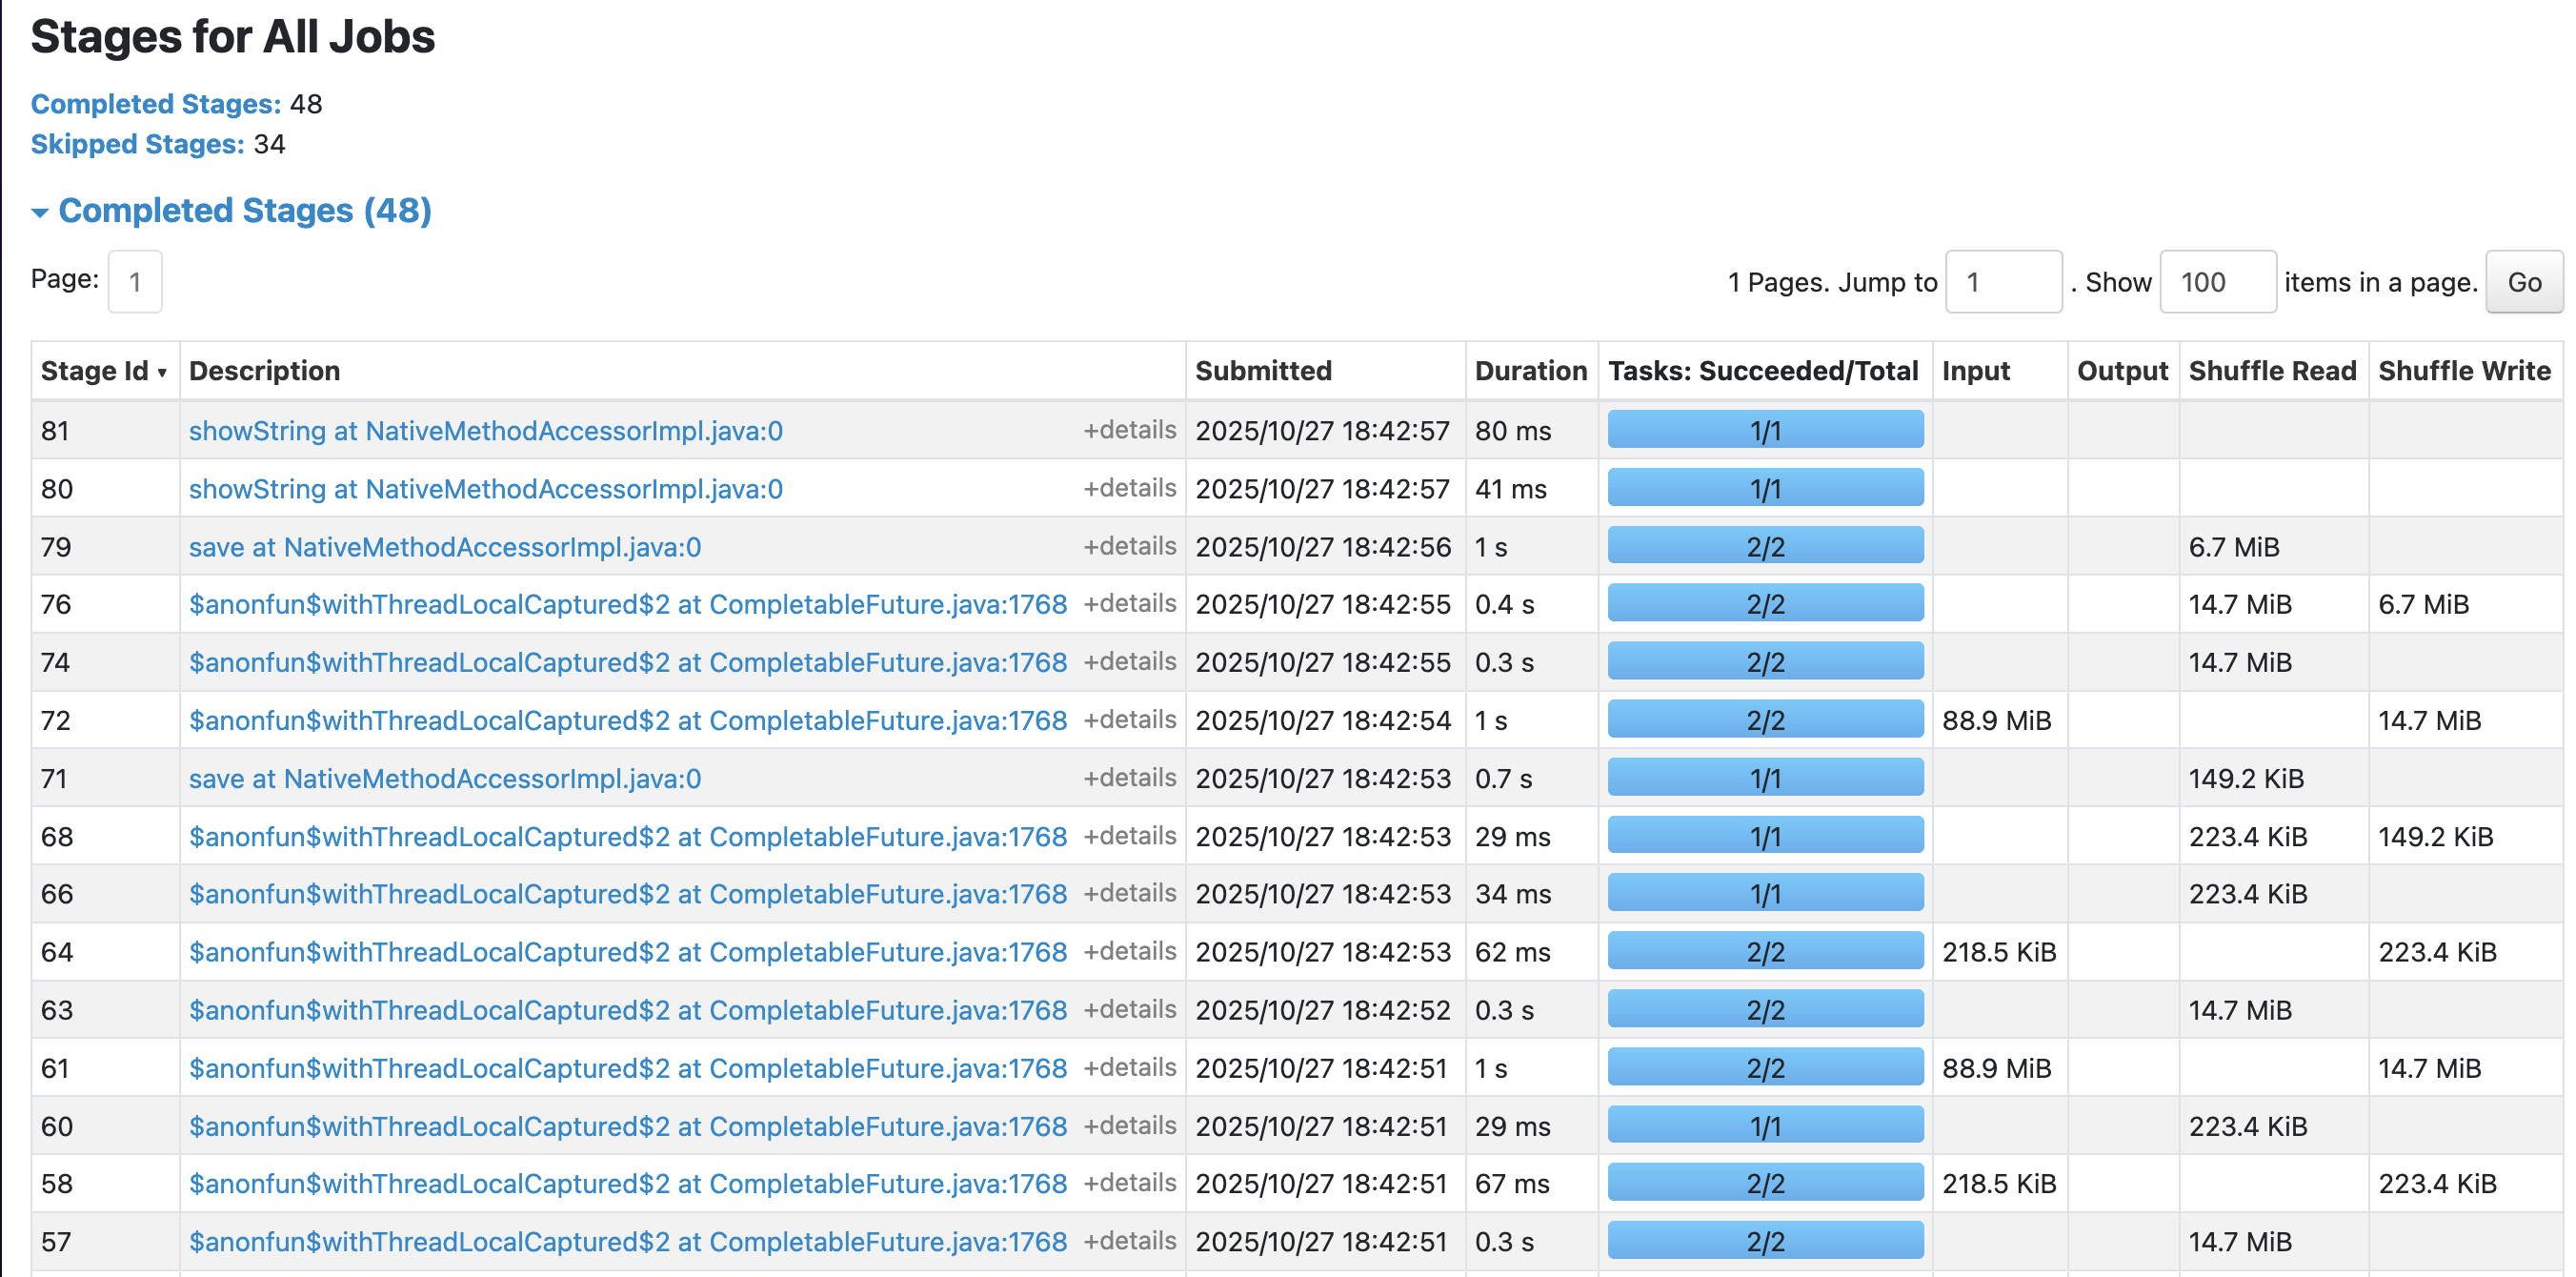

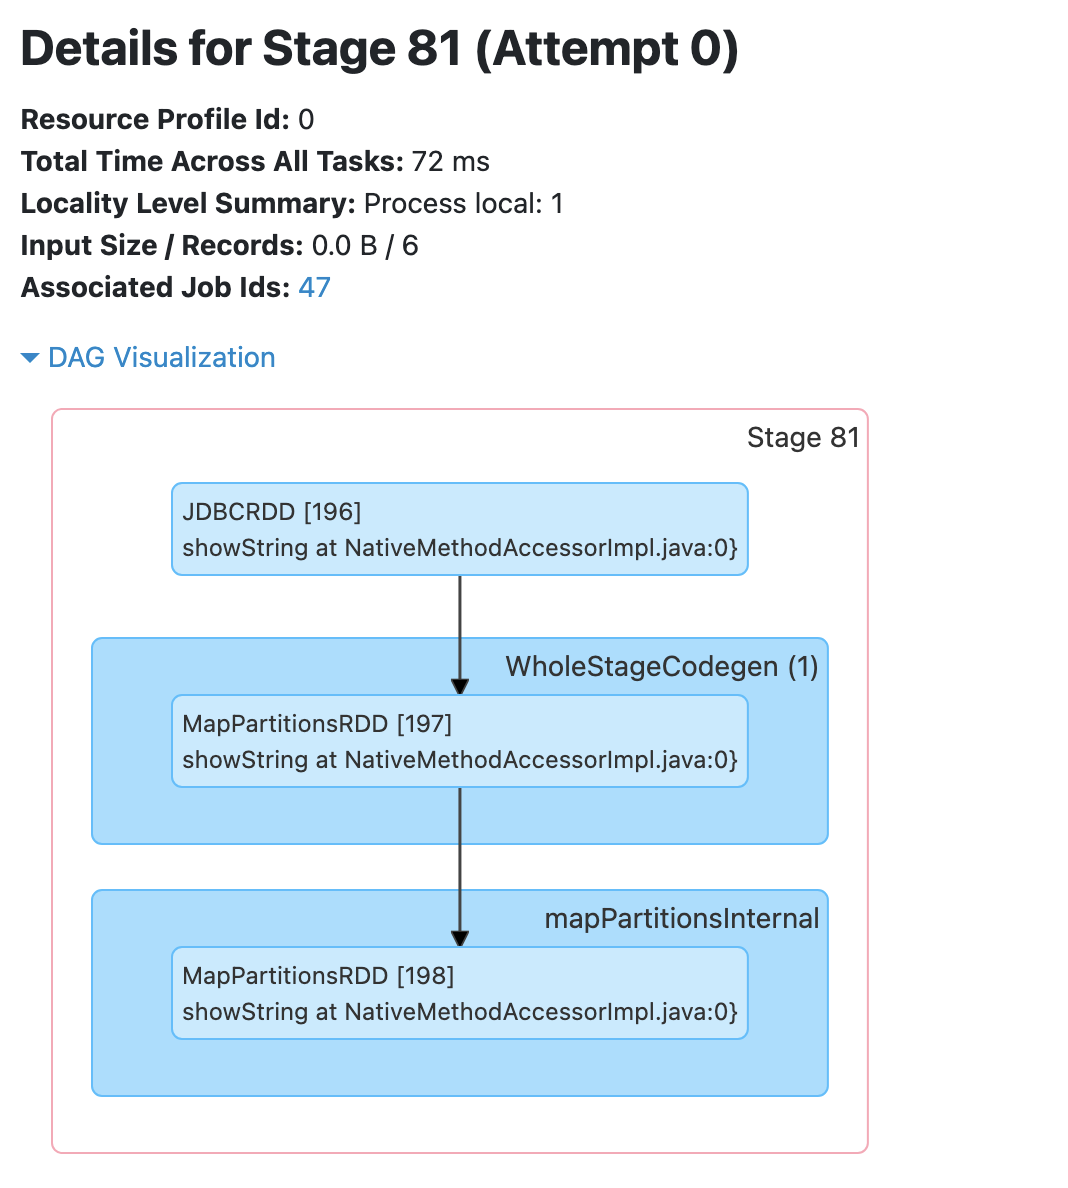